<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : reza vahidimajd
### Student Number : 99102491
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = None # Write your code here
transformation = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307), (0.3081))])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
val_loader = DataLoader(valid_data, batch_size = 16, shuffle = True)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1acQve-TOYd6wYtogpHCblhoDZt9jWQdf/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [6]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
      super().__init__()
      self.network1 = nn.Sequential(
          nn.Conv2d(1,16,3, padding = 1),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.network2 = nn.Sequential(
          nn.Conv2d(16,16,3, padding = 1),
          nn.ReLU(),
          nn.Conv2d(16,16,3, padding = 1),
          nn.ReLU()
      )
      self.network3 = nn.Sequential(
          nn.MaxPool2d(2),
          nn.Conv2d(16,64,3, padding = 1),
          nn.ReLU()
      )
      self.network4 = nn.Sequential(
          nn.Conv2d(64,64,3, padding = 1),
          nn.ReLU(),
          nn.Conv2d(64,64,3, padding = 1),
          nn.ReLU()
      )
      self.pool = nn.AdaptiveAvgPool2d(1)
      self.lin = nn.Linear(64, 10)
      
        
    def forward(self, x):
        
        x = self.network1(x)
        x = x + self.network2(x)
        x = self.network3(x)
        x = x + self.network4(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.lin(x)
        return x

# Train Model (30 Points)

In [7]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
import copy

best_model = None

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
def train_val():
    best_acc = 0
    total_step = len(train_loader)
    num_epochs = 20
    for epoch in range(num_epochs):
        train_acc = 0
        train_loss = 0
        val_acc = 0
        val_loss = 0
        model.train()
        for images, labels in train_loader:
            #images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item() * len(images)
            loss.backward()
            optimizer.step()


            preds = np.argmax(outputs.detach().numpy(), axis=1)

            for x in range(len(preds)):
                if preds[x] == labels[x]:
                    train_acc += 1

            #pass # Write your code here
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * len(images)
                #pass # Write your code here
                preds = np.argmax(outputs.detach().numpy(), axis=1)

                for x in range(len(preds)):
                    if preds[x] == labels[x]:
                        val_acc += 1

        val_acc /= 10000
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(model)
        train_loss /= 50000
        val_loss /= 10000
        train_acc /= 50000    

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracy.append(train_acc)
        val_accuracy.append(val_acc) 
        print(str(train_loss) + "\t" + str(train_acc))   

train_val()

0.3260687695348961	0.89144
0.08522480080791982	0.97464
0.05750585364299943	0.98258
0.04543900956057536	0.9858
0.03736740050295495	0.9882
0.029879149491866992	0.99086
0.02605938876684322	0.99176
0.02241290211239972	0.99302
0.019250731373381093	0.99406
0.016412135998469874	0.99466
0.014931033670245382	0.9952
0.01328798651197289	0.9958
0.012190805740512806	0.99594
0.010748475448744157	0.99634
0.010269421174792853	0.99628
0.009807070169149106	0.99666
0.009819791779583364	0.99654
0.007823907240543675	0.9972
0.007916480328479495	0.99748
0.009214825374345896	0.99688


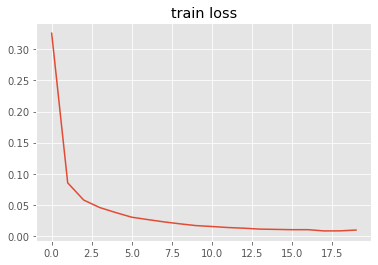

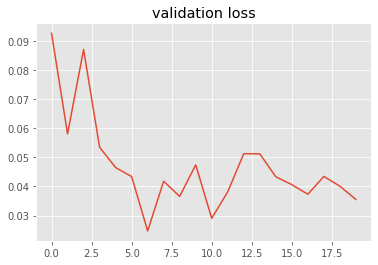

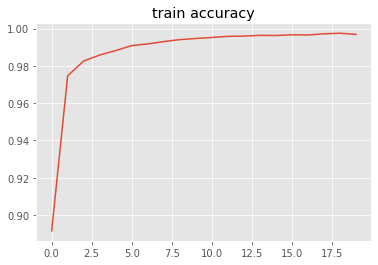

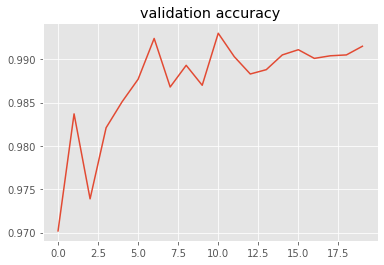

In [9]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.title("train loss")
plt.plot(train_losses)
plt.show()
plt.title("validation loss")
plt.plot(val_losses)
plt.show()
plt.title("train accuracy")
plt.plot(train_accuracy)
plt.show()
plt.title("validation accuracy")
plt.plot(val_accuracy)
plt.show()

# Test Model (20 Points)

10000
test accuracy: 0.9915


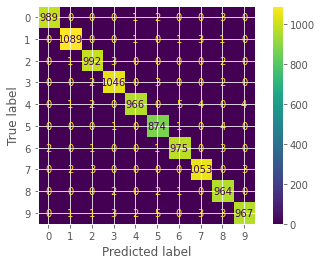

In [10]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

test_acc = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
          outputs = model(images)
          #pass # Write your code here
          preds = np.argmax(outputs.detach().numpy(), axis=1)

          for x in range(len(preds)):
              all_preds.append(preds[x])
              all_labels.append(labels[x])
              if preds[x] == labels[x]:
                  test_acc += 1

    test_acc /= len(test_data)

print("test accuracy: " + str(test_acc))
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm).plot()